<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

## Simulate the runout extent, sediment transport and topographic change caused by a moderatly sized landslide in the Cascade Mountains, WA USA

#### In this tutorial, the user loads the mapped extent of an observed landslide, defines the landslide thickness, parameterizes MassWastingRunout (MWR) and models the runout of the landslide down a first-to-second order channel that intersects two roads, towards a river valley at the base of the slope. At the end of the notebook, a DEM-of-Difference of the modeled runout is visually compared with a DEM-of-Difference of the observed runout.

#### Model overview
- MWR models the downslope progression of mass wasting processes such as debris flows or dry debris avalanches.

- Mass continuity is central to model conceptualization; at any node, the incoming flux (q_I) erosion (E) and aggradation A) determine outgoing flux (q_O) and ultimtely the runout extent and how the landscape evolves. 

<div>
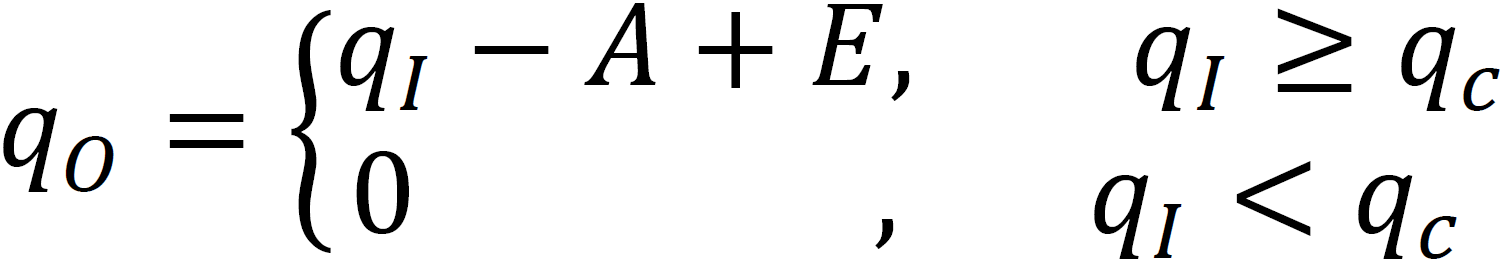
<div>    

- MWR uses a set of rules and algorithms to numercally represent the release of the mass wasting source material and erosion, deposition and vegetation/debris impacts on the runout process as illustrated below:

<div>
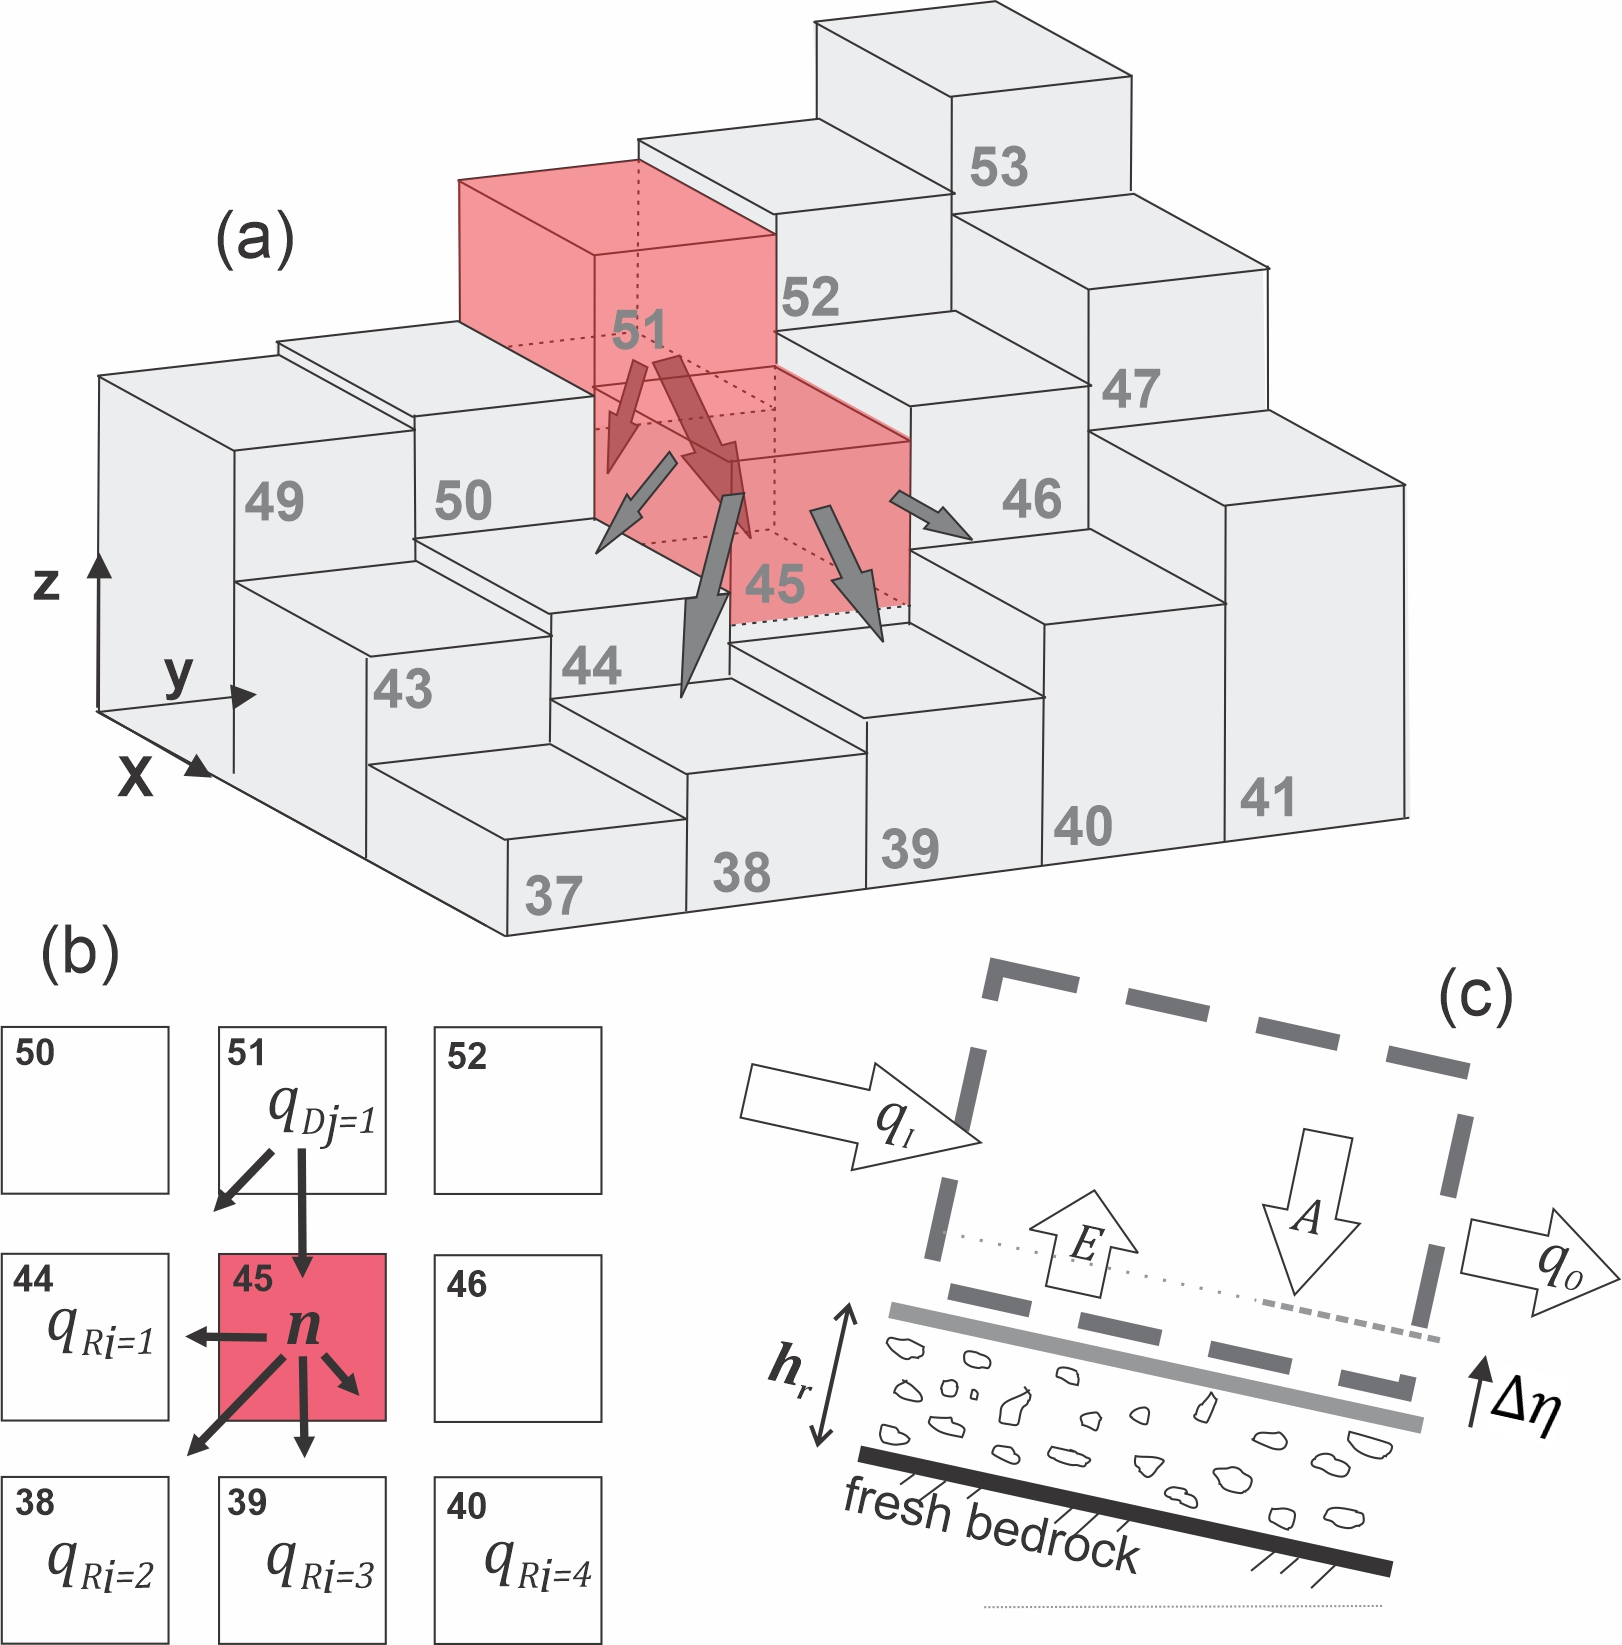
<div>

<strong><em>(a)</em></strong> Release of the initial mass wasting source material nodes (represented by red cells) <strong><em>(b)</em></strong> How q_O at node n is distributed downslope after incoming material q_I (here equal to q_Dj=1) has aggraded (A) or eroded (E) node n <strong><em>(c)</em></strong> Mass continuity determines the change in regolith/topographic surface. For a full description of the above parameters, see Keck et al. (2024). 

#### First import  packages and components necessary to run MWR and visualize results

In [ ]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

from landlab import imshow_grid_at_node
from landlab.components import (
    DepressionFinderAndRouter,
    FlowAccumulator,
    FlowDirectorMFD,
)
from landlab.components.mass_wasting_runout import MassWastingRunout
from landlab.io import read_esri_ascii

#### Next, define key MWR parameters S_c, q_c and k and attributes to be tracked by the model.<br>
In MWR, S_c is a critical slope constraint. For some flows, S_c can be approximated from the surface slope of observed deposits. The parameter q_c is the threshold flux for deposition, that conceptually represents the flow depth below which flow resistance is large enough to cease the forward momentum of the flow, whether in the form of frictional resistance along the base of the flow or debris and vegetation in the path of the flow. Parameter k scales the erosion rate.<br>

Calibration may be required to determine single values of S_c and q_c that parameterize MWR to a site while other model parameters can be determined directly from a site. 

In [ ]:
# Model parameters, determined through calibration using the MWR Calibrator utility
S_c = [0.156]
q_c = 0.766

# Model parameters, determined from field and DEM of Difference
k = 0.0337443
typical_flow_thickness_of_erosion_zone = 2
typical_slope_of_erosion_zone = 0.25
max_flow_depth_observed_in_field = 5
Dp = 0.316

# regolith and runout material attributes that will be tracked
tracked_attributes = ["particle__diameter"]

#### Now, define a few functions for visualizing model results.<br>
These functions are only included in this notebook for visualization and are not necessary to run the model.

In [ ]:
# plotting functions


def plot_node_field_with_shaded_high_res_dem(
    mg,
    mg_hs,
    field,
    save_name=None,
    plot_name=None,
    figsize=(7, 7),
    cmap="terrain",
    fontsize=10,
    alpha=0.5,
    cbr=None,
    norm=None,
    allow_colorbar=True,
    colorbar_label=None,
    var_name=None,
    var_units=None,
    domain_buffer=0,
    **kwds,
):
    if plot_name is None:
        plt.figure(field, figsize=figsize)
    else:
        plt.figure(plot_name, figsize=figsize)

    imshow_grid_at_node(
        mg_hs,
        "hillshade_arc",
        cmap="Greys_r",
        grid_units=("coordinates", "coordinates"),
        shrink=0.75,
        var_name=None,
        var_units=None,
        output=None,
        allow_colorbar=False,
        color_for_background="white",
        color_for_closed="white",
        limits=(0, 360),
    )
    imshow_grid_at_node(
        mg,
        field,
        cmap=cmap,
        grid_units=("coordinates", "coordinates"),
        shrink=0.75,
        var_name=var_name,
        var_units=var_units,
        alpha=alpha,
        output=None,
        color_for_closed=None,
        color_for_background=None,
        norm=norm,
        allow_colorbar=allow_colorbar,
        colorbar_label=colorbar_label,
    )

    plt.xlim(
        [
            mg.x_of_node[mg.core_nodes].min() - 20,
            mg.x_of_node[mg.core_nodes].max() + domain_buffer,
        ]
    )
    plt.ylim(
        [
            mg.y_of_node[mg.core_nodes].min() - 20,
            mg.y_of_node[mg.core_nodes].max() + domain_buffer,
        ]
    )

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    if cbr is None:
        r_values = mg.at_node[field][mg.core_nodes]
        plt.clim(r_values.min(), r_values.max())
    else:
        plt.clim(cbr[0], cbr[1])

    if save_name is not None:
        plt.savefig(save_name + ".png", dpi=300, bbox_inches="tight")


def get_values_xy(grid, field):
    # convert grid array to input for pcolormesh (from imshow_grid)
    values = grid.at_node[field]
    values = values.reshape(grid.shape)
    y = (
        np.arange(values.shape[0] + 1) * grid.dy
        - grid.dy * 0.5
        + grid.xy_of_lower_left[1]
    )
    x = (
        np.arange(values.shape[1] + 1) * grid.dx
        - grid.dx * 0.5
        + grid.xy_of_lower_left[0]
    )
    return x, y, values


# plotting function
def color_mesh_vals(clim=[-1, 1]):
    x, y, values = get_values_xy(mg, "dem_dif_m")
    myimage = plt.pcolormesh(x, y, values, cmap="bwr", alpha=0.5)
    myimage.set_rasterized(True)
    myimage.axes.set_aspect("equal")
    plt.autoscale(tight=True)
    plt.clim(clim)
    return myimage

#### Next, load GIS inputs onto the raster model grid, including the landslide polygon.<br>
To initiate MWR, the user needs to provide an initial DEM, a regolith depth map and the location and depth of the mass wasting source material (e.g., landslide body). In this example, the required inputs have been prepared using an external GIS system. The number of rows and columns and grid size (10 meter) of each input is the same. Below we load each and add them as fields to a raster model grid. We also load a high-resolution hillshade of the model domain that will be used for visualizing model results.

In [ ]:
# GIS generated inputs
DEM_pre = "pre_runout_DEM.asc"
DEM_pre_hs = "pre_runout_DEM_hillshade.asc"  # high (2-meter resolution)
lsnodes = "landslide_polygon.asc"  # nodes within the mapped landslide
DoDo = "DEM_of_Difference.asc"  # observed DEM of difference
ls_depth = "landslide_depth.asc"  # measured depth at each node

# dem
mg, z = read_esri_ascii(DEM_pre, name="topographic__elevation")

# ls nodes
_, mw1 = read_esri_ascii(lsnodes, name="mass__wasting_id")
mg.add_field("node", "mass__wasting_id", mw1.astype(int))

# observed DoD
_, mw1 = read_esri_ascii(DoDo, name="dem_dif_o")
mg.add_field("node", "dem_dif_o", mw1)
mg.at_node["dem_dif_o"][
    mg.at_node["dem_dif_o"] == -9999
] = 0  # change null values to zero

# create a modeled DoD field, to be updated later to show animation of modeled DoD
mg.at_node["dem_dif_m"] = np.zeros(mg.number_of_nodes)  #

# soil depth
depth = (
    np.ones(mg.at_node["topographic__elevation"].shape[0]) * 1.2
)  # here using uniform depth of 1.2 meters
mg.add_field("node", "soil__thickness", depth)

# set landslide thickness (depth) equal to measured depth from DEM of Difference
_, lsd = read_esri_ascii(ls_depth, name="ls_depth")
lsd = lsd[lsd != -9999]
mg.at_node["soil__thickness"][mg.at_node["mass__wasting_id"] == 1] = -1 * lsd

# high res hillshade for plot background
mg_hs, hs = read_esri_ascii(DEM_pre_hs, name="hillshade")
mg_hs.at_node["hillshade_arc"] = hs
mg_hs.at_node["hillshade_arc"][mg_hs.at_node["hillshade_arc"] == -9999] = np.nan

mg.set_watershed_boundary_condition(
    z
)  # finds lowest point in dem and sets it as an open node

# add particle diameter
mg.at_node["particle__diameter"] = (
    np.ones(len(mg.node_x)) * Dp
)  # representative grain size of regolith

# flow accumulater to get contributing area to each grid cell. We initially use the FlowDirectorD8 option
# to visualize topographic slope but will replace the flow router with the MFD option later in this notebook
# because MWR uses the multi-directional slope.
fa = FlowAccumulator(mg, "topographic__elevation", flow_director="FlowDirectorD8")
fa.run_one_step()

# fill depressions to correct surface area determination
df_4 = DepressionFinderAndRouter(mg)
df_4.map_depressions()

# save a copy of the initial elevation for dem differencing
_ = mg.add_field(
    "topographic__initial_elevation",
    mg.at_node["topographic__elevation"],
    at="node",
    copy=True,
)

#### Before we instantiate and run the model, lets visualize some of the loaded inputs to get a feel for the landslide geometry relative to the terrain it flowed down

The landslide body was an enlargment of an existing landslide. It formed along the edge of a scarp left by previous landslide activity. Downslope of the landslide, a first-to-second order channel drains the center of the hillslope and two forest roads cross the channel. Both road crossing are large fills that effectively create check dams in the runout path of the landslide.

Below, you see the mapped landslide, represented by the nodes (shown as dark cells) of the 10-meter grid that were located within the mapped extent of the landslide. Note the model is run using a 10-meter grid but for visualization purposes, we show model inputs and results overlayed on top of a high-resultion (2-meter) hillshade of the terrain. You can see the two road crossings.

In [ ]:
%matplotlib inline
plt.figure()
plot_node_field_with_shaded_high_res_dem(
    mg, mg_hs=mg_hs, field="mass__wasting_id", cmap="binary", cbr=[0, 1]
)

In the next figure, slope is shown. You can see that there is an area of moderate-to-low slope (green and blue cells) between the two roads

In [ ]:
%matplotlib inline
plt.figure()
plot_node_field_with_shaded_high_res_dem(
    mg=mg,
    mg_hs=mg_hs,
    field="topographic__steepest_slope",
    cmap="gist_ncar",
    cbr=[0, 1],
)
plt.show()

Below is the DEM of Difference of the observed runout. Red indicates a positive change in the elevation of the terrain (aggradation) and blue indicates a negative change (erosion). Notice how the observed runout eroded along the steep reaches and deposited in the moderate to low slope reaches. It also formed thick deposits upchannel of the road crossings. It eroded the upper road surface but not the surface of the lower road. Only a small amount of the observed runout actually flowed into the river at the base of the hillslope.

In [ ]:
%matplotlib inline
plt.figure()
plot_node_field_with_shaded_high_res_dem(
    mg, mg_hs=mg_hs, field="dem_dif_o", cmap="bwr", alpha=0.5, cbr=[-1, 1]
)
plt.show()

#### Now set up an instance of MWR using the newly defined raster model grid and the landslide and watch a calibrated recreation of the observed runoutl! <br>
Before we instantiate the model, we need to switch the topographic__steepest_slope and other related flow routing fields from the D8 flow routing option to the multidirectional routing option. MWR uses multi-directional slope. 

In [ ]:
# multiflow direction for MWRu
# need to delete d8 flow direction
mg.delete_field(loc="node", name="flow__sink_flag")
mg.delete_field(loc="node", name="flow__link_to_receiver_node")
mg.delete_field(loc="node", name="flow__receiver_node")
mg.delete_field(loc="node", name="topographic__steepest_slope")

# run flow director, add slope and receiving node fields
fd = FlowDirectorMFD(mg, diagonals=True, partition_method="slope")
fd.run_one_step()

# set model parameters
MWR = MassWastingRunout(
    grid=mg,
    critical_slope=S_c,
    threshold_flux=q_c,
    erosion_coefficient=k,
    tracked_attributes=tracked_attributes,
    save=True,
    typical_flow_thickness_of_erosion_zone=typical_flow_thickness_of_erosion_zone,
    typical_slope_of_erosion_zone=typical_slope_of_erosion_zone,
    max_flow_depth_observed_in_field=max_flow_depth_observed_in_field,
)

MWR.run_one_step()

#### Once the model has finished running, view an animation of the modeled DEM-of-Difference. <br>

In [ ]:
%matplotlib notebook


# update function
def update_plot(frame_number, MWR, plot):
    mg.at_node["dem_dif_m"] = (
        MWR.saver.runout_evo_maps[0][frame_number]
        - mg.at_node["topographic__initial_elevation"]
    )
    plot[0].set_array(mg.at_node["dem_dif_m"])
    plot[0].remove()
    plot[0] = color_mesh_vals(clim=[-1, 1])


# prepare the first frame
fig = plt.figure(figsize=(8, 8))
nmax = len(MWR.saver.runout_evo_maps[0].keys())
x, y, values = get_values_xy(mg_hs, "hillshade_arc")
myimage = plt.pcolormesh(x, y, values, cmap="Greys_r", alpha=1)
myimage.set_rasterized(True)
myimage.axes.set_aspect("equal")
plt.autoscale(tight=True)
plot = [color_mesh_vals(clim=[-1, 1])]
plt.title("dem_dif_m")
cb = plt.colorbar(norm=True)

animate_10 = animation.FuncAnimation(
    fig,
    update_plot,
    nmax,
    fargs=(MWR, plot),
    blit=True,
    repeat=True,
    cache_frame_data=False,
)

MWR replicates the observed DEM-of-Difference and allows us to see how observed runout may have progressed. The word "may" is necessary because MWR excludes momentum and other processes that may have controlled the observed runout. MWR may replicate observed erosion and depositional patterns without accurately mimicing the process that created the patterns. <br>
Nontheless, from this modeled  recreation, we can watch how the landslide first deposits shortly downslope of where it initiated. It then erodes in the steep, narrow reach until it reaches the upper road crossing. At the upper road crossing, flow over the road partially erodes the road surface. It then spreads and deposits on the moderatly-sloped sloped region below the upper road before it being funneled into another narrow, steep reach. Finally, it intersects the lower road crossing, where it gradually fills the area uplsope of the crossing untill a small volume of the flow continues over and past the lower road to reach the river below. 

#### Now that you've seen an example of how a calibrated MWR can  replicate observed runout, try re-running this notebook with different parameter values to see if you can send more sediment into the river valley below the second road crossing!